# Standalone Training of Hamiltonian Flow Map for 1D Harmonic Oscillator [PyTorch]

**Disclaimer**: This is the PyTorch equivalent of our standalone example notebook. Since the rest of the codebase is in jax, the jax notebook might be easier to follow. 

In physics and chemistry, we often need to simulate how atoms or other particles move over time according to Newton's laws.

**Hamiltonian Systems**: A Hamiltonian system is a physical system described by positions and momenta. Examples include:
- Molecular dynamics (atoms moving under inter-atomic forces)
- Planetary motion

The dynamics follow *Hamilton's equations*:
$$\frac{dx}{dt} = \frac{\partial H}{\partial p}, \quad \frac{dp}{dt} = -\frac{\partial H}{\partial x}$$

where $H$ is the Hamiltonian, $x$ is position, and $p$ is momentum. 

**Integration of Newton's laws**: Traditional integration methods like **Velocity Verlet** are accurate only for very small timesteps. This means simulating even short time periods requires thousands or millions of integration steps, making simulations extremely slow.

We propose learning a **Hamiltonian Flow Maps (HFM)**, i.e. learning a neural network that can predict how a system evolves over **much larger timesteps** while remaining stable and accurate. This is like learning a shortcut that replaces many small integration steps with one large leap.

This notebook demonstrates the complete pipeline on the simplest possible system: a **1D Harmonic Oscillator** (like a mass on a spring). It shows the full algorithm in action.
Below you can see a visual comparison between integration using a classic integrator and Hamiltonian Flow Maps:

<img src="assets/vv_vs_hfm.png" alt="Velocity Verlet vs. HFM integration" title="VV vs. HFM" style="width: 600px; border: 15px solid white;">

You'll see:
1. Generating training data for the 1D harmonic oscillator
2. Training a neural network using mean flow consistency
3. Using the learned network to integrate with large timesteps
4. Visualizing generated trajectories to show that the method works

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm
from torch.func import jvp

# Set seed for reproducibility
torch.manual_seed(42)

## Section 1: Generate Training Data

The harmonic oscillator follows the energy-conserving dynamics:
$$H(x,p) = \frac{p^2}{2m} + \frac{1}{2}kx^2$$

For simplicity, we set mass $m=1$ and spring constant $k=1$, giving us:
$$\frac{dx}{dt} = p, \quad \frac{dp}{dt} = -x$$

At a constant energy level ($E=1$ in our case), the system traces a circular orbit in position-momentum (phase) space. We can visualize this orbit as all the valid $(x, p)$ pairs.

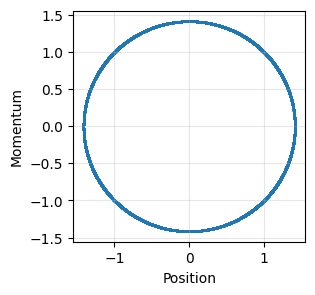

In [ ]:
# Set seed for reproducibility
torch.manual_seed(42)

n_samples = 30_000
total_energy = 1.0
xrange = torch.sqrt(2*torch.tensor(total_energy))

# Randomly sample phase space - no trajectory information is needed
phi = torch.rand((n_samples, 1)) * 2 * np.pi
xs = torch.sqrt(2*torch.tensor(total_energy)) * torch.cos(phi)
ps = - torch.sqrt(2*torch.tensor(total_energy)) * torch.sin(phi)

# Visualize generated data
plt.figure(figsize=(3, 3))
plt.scatter(xs.flatten().numpy(), ps.flatten().numpy(), s=1, alpha=0.5)
plt.xlabel('Position')
plt.ylabel('Momentum')
plt.grid(True, alpha=0.3)
plt.savefig('data.png')

# Save data to numpy
# Here we also store momenta to accelerate convergence
# We could also just sample momenta randomly during training
momenta = ps.reshape(-1, 1, 1)
positions = xs.reshape(-1, 1, 1)

np.savez("ho_data.npz", R=positions.numpy(), momenta=momenta.numpy(), F=-positions.numpy())

**What we're storing**:
- `R`: Random positions on the energy-conserving circle
- `momenta`: The corresponding momenta / velocities (mass=1)
- `F`: The forces at each point (for our simple harmonic oscillator: $F = -x$)

**Important**: 
This data is completely unordered. **We don't need trajectories!** 
Unlike other machine learning approaches to learn large-timestep dynamics, we can learn from *any point in phase space* independently.

## Section 2: Simple Neural Network Model (MLP)

The neural network will learn to predict how $(x, p)$ evolves over time intervals $\Delta t$, but instead of predicting future states, it predicts the *mean velocity* and *mean force* that, when integrated, accurately evolve the state.

**Inputs**:
- $\Delta t$: The time interval (how far to predict)
- $x$: Position 
- $p$: Momentum (=velocity for unit mass)

**Outputs**:
- `mean_v`: How much the position changes on average over time $\Delta t$
- `mean_f`: How much the momentum changes on average over time $\Delta t$

**Architecture Details**:
- Each input ($\Delta t$, $x$, $p$) is embedded separately through a dense layer with SiLU activation
- These embeddings are added together and passed through layer normalization
- Afterwards, we pass through several MLP layers (3 layers, 256 features each)
- Two output heads predict mean_v and mean_f independently

In [ ]:
class SimpleMLP(nn.Module):
    def __init__(self, num_layers: int = 3, num_features: int = 256):
        super().__init__()
        self.num_layers = num_layers
        self.num_features = num_features
        
        # Embeddings
        self.t_embed = nn.Linear(1, num_features)
        self.x_embed = nn.Linear(1, num_features)
        self.p_embed = nn.Linear(1, num_features)
        
        # Layer norm
        self.ln = nn.LayerNorm(num_features)
        
        # Main MLP layers
        self.mlp_layers = nn.ModuleList()
        for _ in range(num_layers):
            self.mlp_layers.append(nn.Linear(num_features, num_features))
        
        # Output heads - initialize with n_dim=1 (assuming 1D harmonic oscillator)
        self.mean_v_head = nn.Linear(num_features, 1)
        self.mean_f_head = nn.Linear(num_features, 1)

    def forward(self, t, x, p):
        org_shape = x.shape
        
        # Flatten inputs
        t = t.reshape(-1, 1)  # Ensure t has shape (batch, 1)
        x_flat = x.reshape(x.shape[0], -1)  # Flatten x to (batch, n_atoms*n_dims)
        p_flat = p.reshape(p.shape[0], -1)  # Flatten p to (batch, n_atoms*n_dims)
        
        # Embeddings
        t_embed = F.silu(self.t_embed(t))
        x_embed = F.silu(self.x_embed(x_flat))
        p_embed = F.silu(self.p_embed(p_flat))
        
        # Combine embeddings
        h = x_embed + p_embed + t_embed
        h = self.ln(h)
        
        # Main MLP layers
        for layer in self.mlp_layers:
            h = layer(h)
            h = F.silu(h)
        
        # Output heads
        mean_v = self.mean_v_head(h)
        mean_f = self.mean_f_head(h)
        
        # Reshape back to original shape
        mean_v = mean_v.reshape(org_shape)
        mean_f = mean_f.reshape(org_shape)
        
        return mean_v, mean_f

## Section 3: Training the Hamiltonian Flow Map

### Training via Mean Flow Consistency

The core insight of this method is that a combination of **force matching** and **mean flow consistency** is sufficient to learn large-timestep dynamics without reference trajectories. Please check [the paper](https://arxiv.org/pdf/2601.22123) for more details.

**Why is this a useful training target?**
- It is derived directly from the Hamiltonian structure
- It automatically regulates self-consistency of the model predictions (predictions with smaller $\Delta t$ will be consistent with those for larger $\Delta t$)
- It doesn't require reference trajectory data

**Loss Function Details**:
- We sample random times $t$ between 0 and `t_max` using a combination of uniform and beta distributions (more samples at small t)
- We compute the network's prediction at $(t, x, p)$ yielding `mean_v_pred`, `mean_f_pred`
- We compute the Jacobian-vector product to get the time derivatives: $\frac{d\text{mean\_v}}{dt}$, $\frac{d\text{mean\_f}}{dt}$
- The target is: `mean_v_target = v + t * d(mean_v)/dt` (and similarly for force)
- The stopgrad prevents expensive repeated differentiation through the jvp
- We minimize MSE between predictions and targets
- Adaptive weighting prevents a few hard examples from dominating the loss

In [ ]:
# Trainer utils
def sample_time(shape=()):
    use_unif = torch.rand(shape) < 0.02
    t_u = torch.rand(shape)
    t_b = torch.distributions.Beta(1.0, 2.0).sample(shape)
    return torch.where(use_unif, t_u, t_b)


def adaptive_weighted_loss(l2_norm_sq, p=.5, c=0.001):
    weight = (l2_norm_sq + c) ** p
    return l2_norm_sq / weight.detach()


def compute_loss(model, sample, device, tmax=1., zero_t_p=1.0):
    x, p, v, f = sample["x"].to(device), sample["p"].to(device), sample["v"].to(device), sample["f"].to(device)
    
    t = sample_time(shape=(x.shape[0],)).to(device)
    t_shaped = t.reshape(-1, 1) * tmax
    zero_t = torch.rand((t_shaped.shape[0], 1), device=device)
    t_shaped = torch.where(zero_t < zero_t_p, torch.zeros_like(t_shaped), t_shaped)
    
    # Define function to compute JVP with
    def model_fn(t_inp, x_inp, p_inp):
        return model(t_inp, x_inp, p_inp)
    
    # Compute predictions and JVP
    primals = (t_shaped, x, p)
    tangents = (-torch.ones_like(t_shaped), v, f)
    
    (mean_v_pred, mean_f_pred), (mean_v_jvp_raw, mean_f_jvp_raw) = jvp(
        model_fn, primals, tangents
    )
    
    # Normalize JVP by output dimension
    batch_size = x.shape[0]
    out_size = mean_v_pred.numel() // batch_size
    
    mean_v_jvp = mean_v_jvp_raw * out_size
    mean_f_jvp = mean_f_jvp_raw * out_size
    
    # Compute targets (these don't have gradients flowing through them)
    mean_v_target = v + t_shaped.detach()[..., None] * mean_v_jvp.detach()
    mean_f_target = f + t_shaped.detach()[..., None] * mean_f_jvp.detach()
    
    # Mean Force/Vel loss per batch (gradients flow through predictions)
    mean_f_loss = ((mean_f_pred - mean_f_target) ** 2).mean(dim=(1, 2))
    mean_v_loss = ((mean_v_pred - mean_v_target) ** 2).mean(dim=(1, 2))
    
    # Adaptive weighted loss
    mean_f_loss_adaptive = adaptive_weighted_loss(mean_f_loss)
    mean_v_loss_adaptive = adaptive_weighted_loss(mean_v_loss)
    l2_loss_adaptive = mean_f_loss_adaptive + mean_v_loss_adaptive
    
    return l2_loss_adaptive.mean()


def make_opt(n_epochs, train_dataset, batch_size, model):
    n_steps = int(n_epochs * len(train_dataset) / batch_size)
    
    # Create learning rate scheduler
    def lr_lambda(current_step):
        warmup_steps = int(0.01 * n_steps)
        decay_steps = int(0.99 * n_steps)
        
        if current_step < warmup_steps:
            return (1e-6 + (1e-4 - 1e-6) * current_step / warmup_steps) / 1e-4
        elif current_step < warmup_steps + decay_steps:
            progress = (current_step - warmup_steps) / decay_steps
            return (1e-4 + (1e-8 - 1e-4) * progress) / 1e-4
        else:
            return 1e-8 / 1e-4
    
    optimizer = optim.Adam(model.parameters(), lr=1e-4, betas=(0.9, 0.95))
    scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)
    
    return optimizer, scheduler


def train_step(model, optimizer, sample, device, tmax, zero_t_p=1.0):
    optimizer.zero_grad()
    loss = compute_loss(model, sample, device, tmax=tmax, zero_t_p=zero_t_p)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
    optimizer.step()
    return loss.item()


def train(model, n_epochs, train_dataset, batch_size, t_max, zero_t_p, device):
    model.to(device)
    optimizer, scheduler = make_opt(n_epochs, train_dataset, batch_size, model)
    
    for _ in tqdm(range(n_epochs)):
        losses = []
        for sample in train_dataset.next_epoch(batch_size):
            loss = train_step(model, optimizer, sample, device, tmax=t_max, zero_t_p=zero_t_p)
            losses.append(loss)
            scheduler.step()
    
    return model

### Dataset Class

Here we define a simple wrapper for the numpy dataset. For each epoch, we randomly shuffle the data and return an iterator. To ensure a consistent shape per batch for jax, we skip the last batch (it has fewer elements than the batches before).

In [ ]:
# Dataset
class Dataset:
    def __init__(self, file_path):
        data = np.load(file_path)
        R = torch.from_numpy(data["R"]).float()
        F = torch.from_numpy(data["F"]).float()
        momenta = torch.from_numpy(data["momenta"]).float()

        self.data = {
            "x": R,
            "f": F,
            "p": momenta,
            "v": momenta  # mass = 1
        }

    def __len__(self):
        return len(self.data["x"])

    def _yield_batch(self, data_epoch, batch_size, start_index):
        batch_data = {k: data_epoch[k][start_index:start_index + batch_size] for k in data_epoch}

        if batch_data["x"].shape[0] < batch_size:
            return None

        return batch_data

    def next_epoch(self, batch_size):
        indices = torch.randperm(len(self))
        data_epoch = {k: self.data[k][indices] for k in self.data}

        n = 0
        while n < len(self):
            sample = self._yield_batch(data_epoch, batch_size, n)

            if sample is None:
                break
            
            yield sample
            n += batch_size

    def get_example_batch(self, batch_size):
        return self._yield_batch(self.data, batch_size, 0)

### Running the Training Loop

**Hyperparameter meanings**:
- `n_epochs = 200`: Train for 200 passes through the data.
- `zero_t_p = 0.75`: With 75% probability, set $\Delta t = 0$. This is important for stable training dynamics, as it balances learning of instantaneous forces and large-timestep dynamics.
- `t_max = 10.0`: Maximum time interval to predict during training ($\Delta t$ ranges from 0 to 10).
- `batch_size = 512`: Number of samples per gradient step.

This training may take a minute or two.

In [ ]:
# Load data and train loop
seed = 42
n_epochs = 200
zero_t_p = 0.75 
t_max = 10.0
batch_size = 512

torch.manual_seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SimpleMLP()
dataset = Dataset("ho_data.npz")
model = train(model, n_epochs, dataset, batch_size, t_max, zero_t_p, device)

100%|██████████| 200/200 [00:25<00:00,  7.85it/s]


## Section 4: Run integration with large timesteps

### Using the Learned Model for Integration

Now that we've trained the network, we can use it as an **integrator** to evolve the system forward in time.

**How it works**:
1. Start with initial position and momentum $(x_0, p_0)$
2. Query the learned network: `mean_v, mean_f = network(Δt, x_0, p_0)`
3. Take a step: 
   - $x_1 = x_0 + Δt \cdot \text{mean\_v}$
   - $p_1 = p_0 + Δt \cdot \text{mean\_f}$
4. Repeat from step 2 with the new state

**Key advantage**: With our approach, we can handle larger timesteps, where classical integrators become unstable.

**Define an integrator class**: The following class wraps the trained network and applies it repeatedly to integrate the dynamics forward in time.

In [ ]:
# First define an integrator class
class HFMIntegrator:    
    def __init__(self, 
                 integration_timestep=None,
                 model=None,
                 device=None):

        self.model = model
        self.device = device
        self.integration_timestep = integration_timestep
        self.model.eval()
            
    def apply_model(self, x, p, integration_timestep):
        with torch.no_grad():
            t = torch.ones((x.shape[0], 1), device=x.device) * integration_timestep
            mean_v, mean_f = self.model(t, x, p)
        
        return mean_v, mean_f

    def __call__(self, x, p, integration_time):
        n_steps = int(integration_time / self.integration_timestep)
        
        xs_list = []
        ps_list = []
        
        for _ in range(n_steps):
            v_pred, f_pred = self.apply_model(x, p, self.integration_timestep)
            x = x + self.integration_timestep * v_pred
            p = p + self.integration_timestep * f_pred
            xs_list.append(x.clone())
            ps_list.append(p.clone())
        
        xs = torch.stack(xs_list, dim=0)
        ps = torch.stack(ps_list, dim=0)
        
        return xs, ps

### Evaluate and visualize the learned flow map

**The visualization**:
- The colored dots show the trajectory over 300 timesteps (total simulation time = 300).
- Each timestep covers $Δt = 1.0$ units of physical time.
- The arrows show the model predictions (mean velocity and mean force as 2d vector), starting from the same initial state but with different Δt.

**What to look for**:
- **Circular orbit**: The generated trajectory traces a closed circle repeatedly, following the true dynamics of the harmonic oscillator.
- **Energy conservation**: For this simple system, our integrator approximately conserves energy, the trajectory is never spiraling outward or inward.
- **Arrow consistency**: The arrows from the start state point to valid future states on the generated trajectory. 
- **Effect of Δt**: For large Δt, predictions get less accurate, which can be alleviated by training longer.

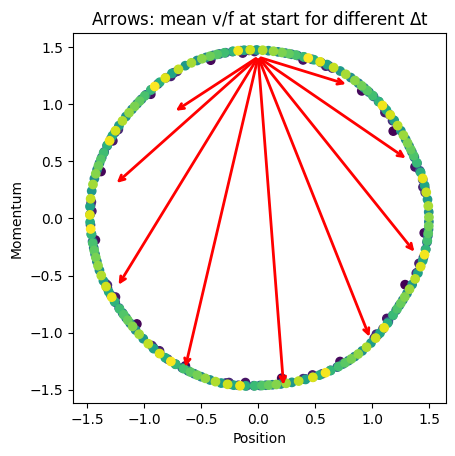

In [ ]:
# Now run the mean flow integrator with a larger time step
n = 10
tmax = 6.0

mf_integrator = HFMIntegrator(integration_timestep=1.0,
                             model=model,
                             device=device)

start_pos = torch.tensor([0.0], device=device).reshape(1, 1, 1)
start_mom = torch.sqrt(torch.tensor([2.0], device=device)).reshape(1, 1, 1)

xs, ps = mf_integrator(start_pos, start_mom, 300.0)

pos_i = start_pos.repeat(n, 1, 1)
mom_i = start_mom.repeat(n, 1, 1)
dt = torch.arange(0, tmax, step=tmax / n, device=device).reshape(-1, 1)

with torch.no_grad():
    t_input = dt
    mean_v, mean_f = model(t_input, pos_i, mom_i)

startx = pos_i.reshape(-1)
starty = mom_i.reshape(-1)
endx = (pos_i + mean_v * dt.reshape(-1, 1, 1)).reshape(-1)
endy = (mom_i + mean_f * dt.reshape(-1, 1, 1)).reshape(-1)

plt.figure()

for i in range(n):
    plt.annotate(
        "", 
        xy=(endx[i].item(), endy[i].item()),        # end point
        xytext=(startx[i].item(), starty[i].item()),    # start point
        arrowprops=dict(arrowstyle="->", color="red", lw=2)
    )

plt.xlabel("Position")
plt.ylabel("Momentum")
plt.title(r"Arrows: mean v/f at start for different $\Delta$t")
scatter = plt.scatter(xs.flatten().cpu().numpy(), ps.flatten().cpu().numpy(), 
                     c=np.arange(xs.shape[0]), cmap='viridis')
plt.gca().set_aspect('equal', adjustable='box')

---

## Section 5: Summary

### The Complete Pipeline

1. **Problem Setup**: We started with a simple but instructive system, a 1D harmonic oscillator

2. **Data Generation**: Instead of using reference trajectory data, we trained on random phase space points sampled from the energy surface

3. **Network Training**: Using mean flow consistency, we trained a neural network to predict how positions and momenta evolve over varying time intervals $\Delta t = 0$ to $10.0$

4. **Learned Integration**: The trained network acts as a new integrator that can take single large steps which are similarly accurate like traditional methods using many tiny steps

### Why This Matters

- **Efficiency**: Speedup compared to standard integrators like Velocity Verlet
- **Scalability**: This same approach works for complex molecular systems with many atoms, as we show in our paper
- **Simplicity**: The training procedure uses decorrelated positions and forces (momenta can be sampled randomly during training)

### Going Further

This notebook showed the standalone algorithm. For applying this to real molecular systems:
- See `examples/harmonic_oscillator.ipynb` for how to use our full HFM infrastructure
- Check the `configs/` directory for configuration examples on real molecules (MD17 dataset, etc.)
- The training code in `hfm/training/` can handle complex systems with multiple atoms

### Paper & Code

- **Paper**: [Learning Hamiltonian Flow Maps](https://arxiv.org/abs/2601.22123)
- **Project Page**: [ml4molsim.github.io/hamiltonian-flow-maps](https://ml4molsim.github.io/hamiltonian-flow-maps/)
- **GitHub Repo**: [github.com/ML4MolSim/hamiltonian-flow-maps](https://github.com/ML4MolSim/hamiltonian-flow-maps)